In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all the words in dict
words = open('names.txt', 'r').read().splitlines()
words[:8]
len(words)

32033

In [3]:
#build character vocabulary and mappings from/to integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
#build the dataset
block_size = 3 # length of context: how many characters needed to predict the next one?
def build_database(words):
    X,Y = [],[]
    for w in words:
        #print(w)
        context = [0] * block_size 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) #80 percent length mark
n2 = int(0.9*len(words)) #90 percent length mark

Xtr, Ytr = build_database(words[:n1]) #training set
Xdev, Ydev = build_database(words[n1:n2]) #dev set
Xte, Yte = build_database(words[n2:]) #testing set
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [6]:
# h = torch.tanh(emb.view(-1,6) @ W1 + b1) #when inputting -1, pytorch will infer the dimmension

In [7]:
#concatenate embeddings for all inputs
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape

In [8]:
# h

In [9]:
learning_rate_exponent = torch.linspace(-3,0,1000)
lrs = 10**learning_rate_exponent #create learning rates between -0.001 and -1
lrs #exponentially stepped between these rates, rather than linearly

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [10]:
max_steps = 200000
batch_size = 32
lossi = [] 

In [11]:
#optimization
for i in range(max_steps):
    #construct mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix] #batch X,Y

    #forward pass 
    emb = C[Xb] #character embeddings into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors, -1 infers shape
    hpreact = embcat @ W1 + b1 #hidden layer before activation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits,Yb) #calculate loss

    #backward pass
    for p in parameters:
        p.grad = None #reset gradient
    loss.backward()

    #update gradient based on lr
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data+= -lr * p.grad

    #track statistics
    if i % 10000 == 0: #print every 1000
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1715
  20000/ 200000: 2.3240
  30000/ 200000: 2.4010
  40000/ 200000: 1.9887
  50000/ 200000: 2.3029
  60000/ 200000: 2.4564
  70000/ 200000: 2.1249
  80000/ 200000: 2.3069
  90000/ 200000: 2.1057
 100000/ 200000: 1.8948
 110000/ 200000: 2.2326
 120000/ 200000: 1.9659
 130000/ 200000: 2.4410
 140000/ 200000: 2.2106
 150000/ 200000: 2.1795
 160000/ 200000: 1.8383
 170000/ 200000: 1.8131
 180000/ 200000: 1.9572
 190000/ 200000: 1.8002


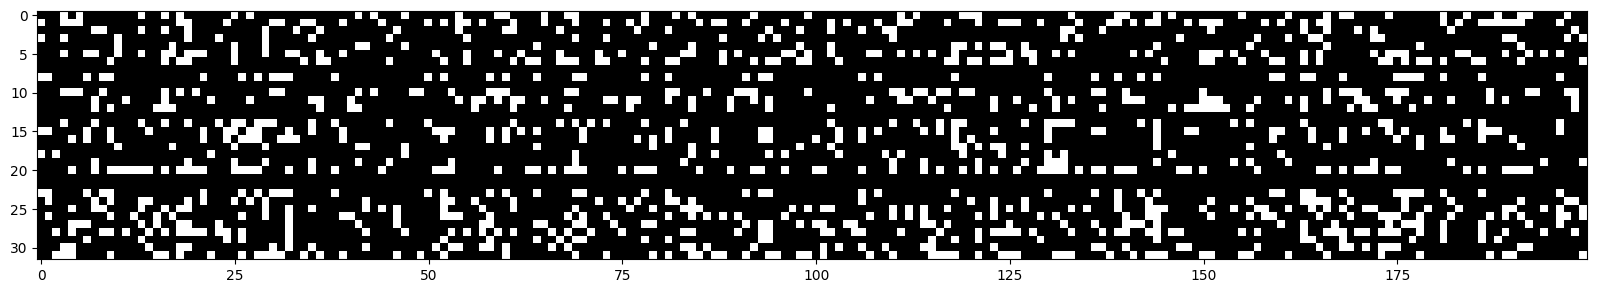

In [12]:
plt.figure(figsize=(20,10)) #visualize the activation of the tanh
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')
#if plot was all white, this would represent a dead nueron

In [15]:
@torch.no_grad() #disables gradient tracking for speed
def split_loss(split):
    x,y = {
        'train': [Xtr,Ytr],
        'val': [Xdev,Ydev],
        'test': [Xte,Yte],
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.036555767059326
val 2.103057384490967


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
        #forward pass nueral net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we get the end token, meaning end of word, break
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

carmahzailyn.
kit.
jarri.
thil.
skanden.
jazhinn.
delynn.
jareei.
nellara.
chaily.
kaleigh.
ham.
joce.
quint.
saline.
liven.
arrothogdifryn.
kai.
eulissa.
med.
